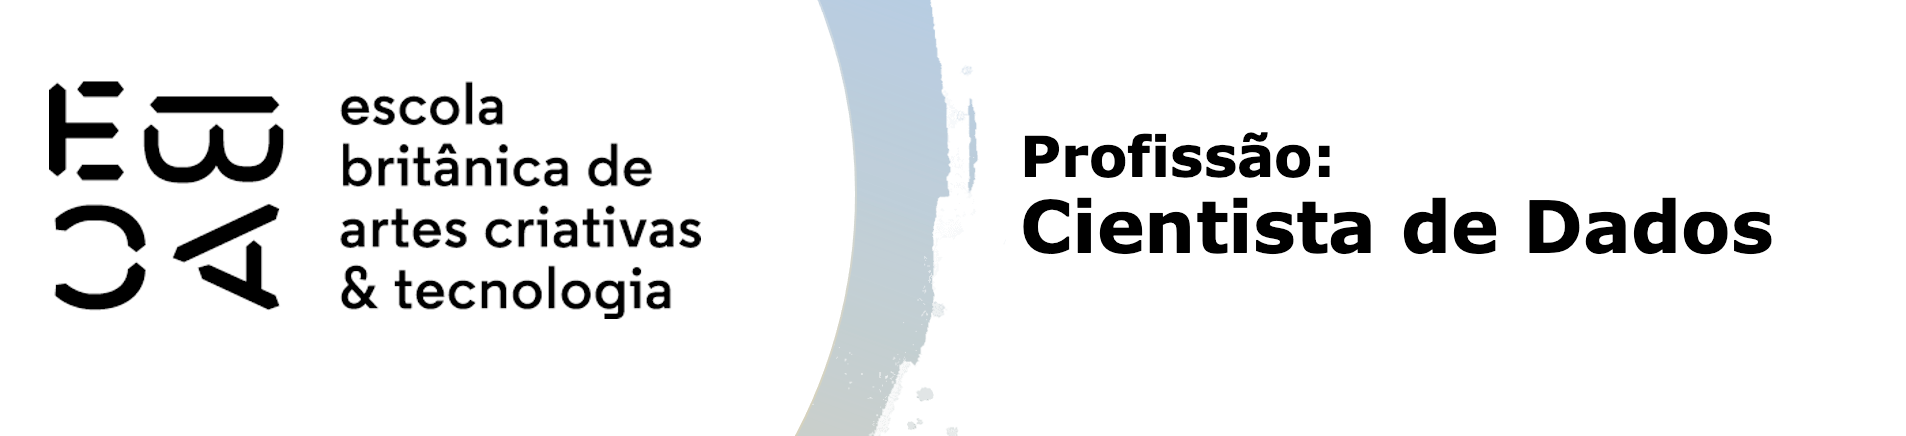

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t
import warnings
warnings.filterwarnings("ignore")
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [2]:
dados = pd.read_feather('./Dados/credit_scoring.ftr')
display(dados.data_ref.value_counts().sort_values())
display(dados.head())

2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: data_ref, dtype: int64

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
df=dados[(dados['data_ref']>='2016-01-01')].copy()
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
600000,2016-01-01,8906,F,S,S,2,Assalariado,Superior completo,Casado,Casa,38,7.383562,4.0,2969.49,True
600001,2016-01-01,5063,F,N,S,0,Assalariado,Médio,Casado,Casa,55,8.471233,2.0,6278.37,False
600002,2016-01-01,16401,M,S,S,1,Assalariado,Médio,União,Casa,39,8.884932,3.0,14010.18,False
600003,2016-01-01,6786,F,N,S,1,Assalariado,Médio,União,Com os pais,31,1.794521,3.0,2875.81,False
600004,2016-01-01,13466,M,S,N,0,Assalariado,Médio,Casado,Casa,27,7.019178,2.0,2737.19,False


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [4]:
# Contagem das linhas por mês
print("Número de linhas por mês")
print("========================")
display(df['data_ref'].dt.to_period('M').value_counts())

# Descrição básica das variáveis qualitativas
var_ql = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'mau']
data_ql = df[var_ql]

for var in var_ql:
    print(f"*** {var} ***")
    print("===="+"="*len(var)+"====")
    display(data_ql[var].value_counts())
    
    print()

# Descrição básica das variáveis quantitativas
var_qt = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
data_qt = df[var_qt]

for var in var_qt:
    print(f"--- {var} ---")
    print("===="+"="*len(var)+"====")
    display(data_qt[var].describe())
    print()

Número de linhas por mês


2016-01    50000
2016-02    50000
2016-03    50000
Freq: M, Name: data_ref, dtype: int64

*** sexo ***


F    100775
M     49225
Name: sexo, dtype: int64


*** posse_de_veiculo ***


N    91661
S    58339
Name: posse_de_veiculo, dtype: int64


*** posse_de_imovel ***


S    100638
N     49362
Name: posse_de_imovel, dtype: int64


*** tipo_renda ***


Assalariado         77280
Empresário          34571
Pensionista         25138
Servidor público    12941
Bolsista               70
Name: tipo_renda, dtype: int64


*** educacao ***


Médio                  101387
Superior completo       40866
Superior incompleto      5912
Fundamental              1674
Pós graduação             161
Name: educacao, dtype: int64


*** estado_civil ***


Casado      105323
Solteiro     18438
União        11577
Separado      8383
Viúvo         6279
Name: estado_civil, dtype: int64


*** tipo_residencia ***


Casa             134958
Com os pais        6502
Governamental      4698
Aluguel            2087
Estúdio            1099
Comunitário         656
Name: tipo_residencia, dtype: int64


*** mau ***


False    128000
True      22000
Name: mau, dtype: int64


--- qtd_filhos ---


count    150000.000000
mean          0.433413
std           0.737417
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          14.000000
Name: qtd_filhos, dtype: float64


--- idade ---


count    150000.000000
mean         43.829547
std          11.226707
min          22.000000
25%          34.000000
50%          43.000000
75%          53.000000
max          68.000000
Name: idade, dtype: float64


--- tempo_emprego ---


count    124918.000000
mean          7.750898
std           6.682998
min           0.117808
25%           3.071233
50%           6.038356
75%          10.183562
max          42.906849
Name: tempo_emprego, dtype: float64


--- qt_pessoas_residencia ---


count    150000.000000
mean          2.212720
std           0.902114
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          15.000000
Name: qt_pessoas_residencia, dtype: float64


--- renda ---


count    150000.000000
mean       7301.344809
std       20778.675831
min         107.670000
25%        1598.627500
50%        2952.380000
75%        5858.200000
max      732561.260000
Name: renda, dtype: float64

                            V A R I Á V E I S   Q U A L I T A T I V A S                             


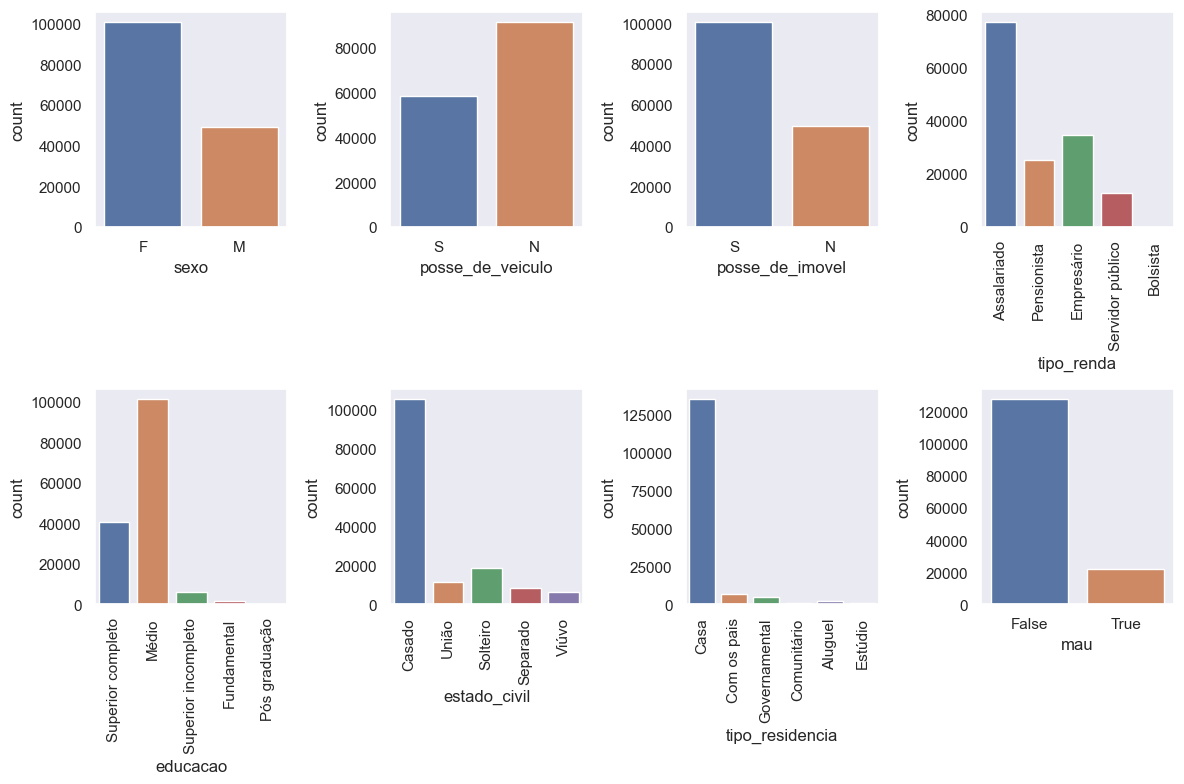

                           V A R I Á V E I S   Q U A N T I T A T I V A S                            


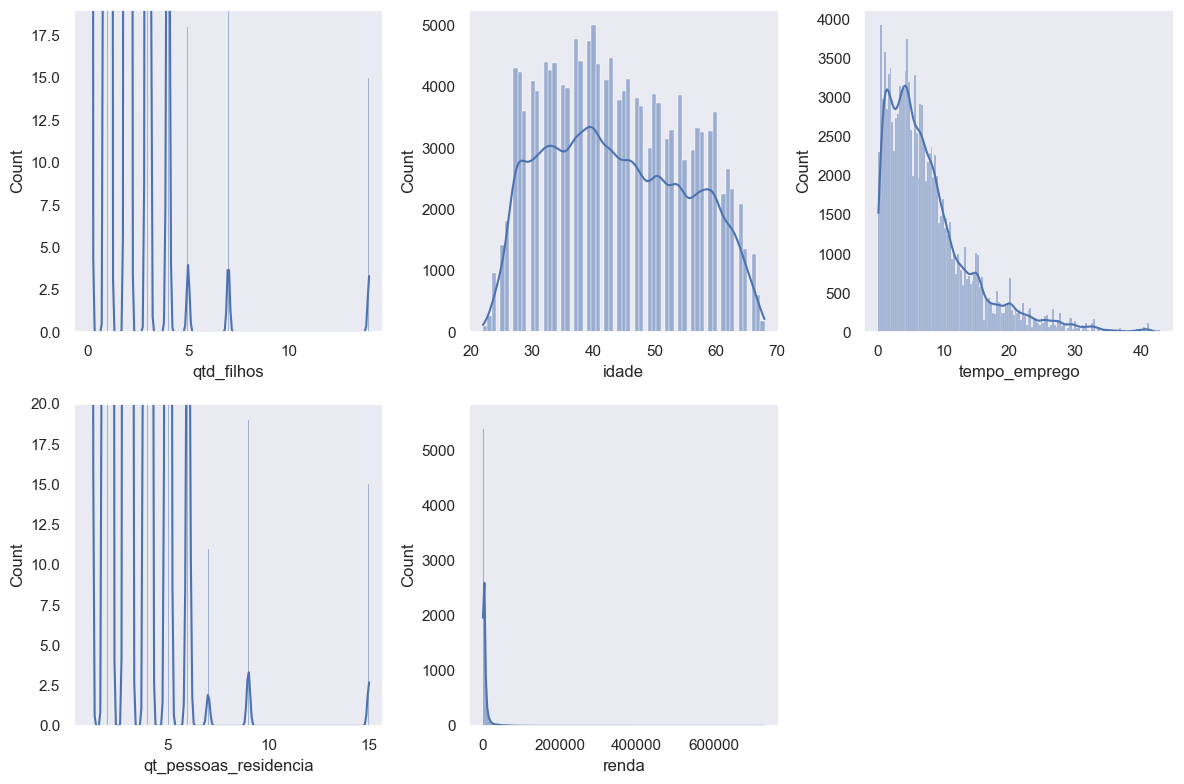

In [5]:
# Configurações dos gráficos
sns.set(style="dark")

# Gráficos para as variáveis qualitativas
var_ql = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'mau']
num_var_ql = len(var_ql)

plt.figure(figsize=(12, 8))
print('V A R I Á V E I S   Q U A L I T A T I V A S'.center(100))
for i, var in enumerate(var_ql):
    plt.subplot(2, (num_var_ql+1)//2, i+1)
    sns.countplot(data=df, x=var)
    # Orientação do label do eixo x
    if var in ['sexo', 'mau','posse_de_veiculo','posse_de_imovel']:
        plt.xticks(rotation=0)
    else:
        plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

# Gráficos para as variáveis quantitativas
var_qt = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
num_var_qt = len(var_qt)

plt.figure(figsize=(12, 8))
print('V A R I Á V E I S   Q U A N T I T A T I V A S'.center(100))

for i, var in enumerate(var_qt):
    plt.subplot(2, (num_var_qt+1)//2, i+1)
    sns.histplot(data=df, x=var, kde=True)
#     plt.title(var)
    if var in ['qtd_filhos', 'qt_pessoas_residencia']:
        max_value = df[var].max()
        plt.ylim(0, max_value + 5)  # Definir limite superior do eixo y
    else:
        plt.ylim(0)  # Definir limite inferior do eixo y como 0
#     plt.xticks([])  # Ocultar os valores do eixo x
sns.set(style="whitegrid")
plt.tight_layout()
plt.show()


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

                      ANÁLISE DESCRITIVA BIVARIADA DAS VARIÁVEIS QUALITATIVAS                       


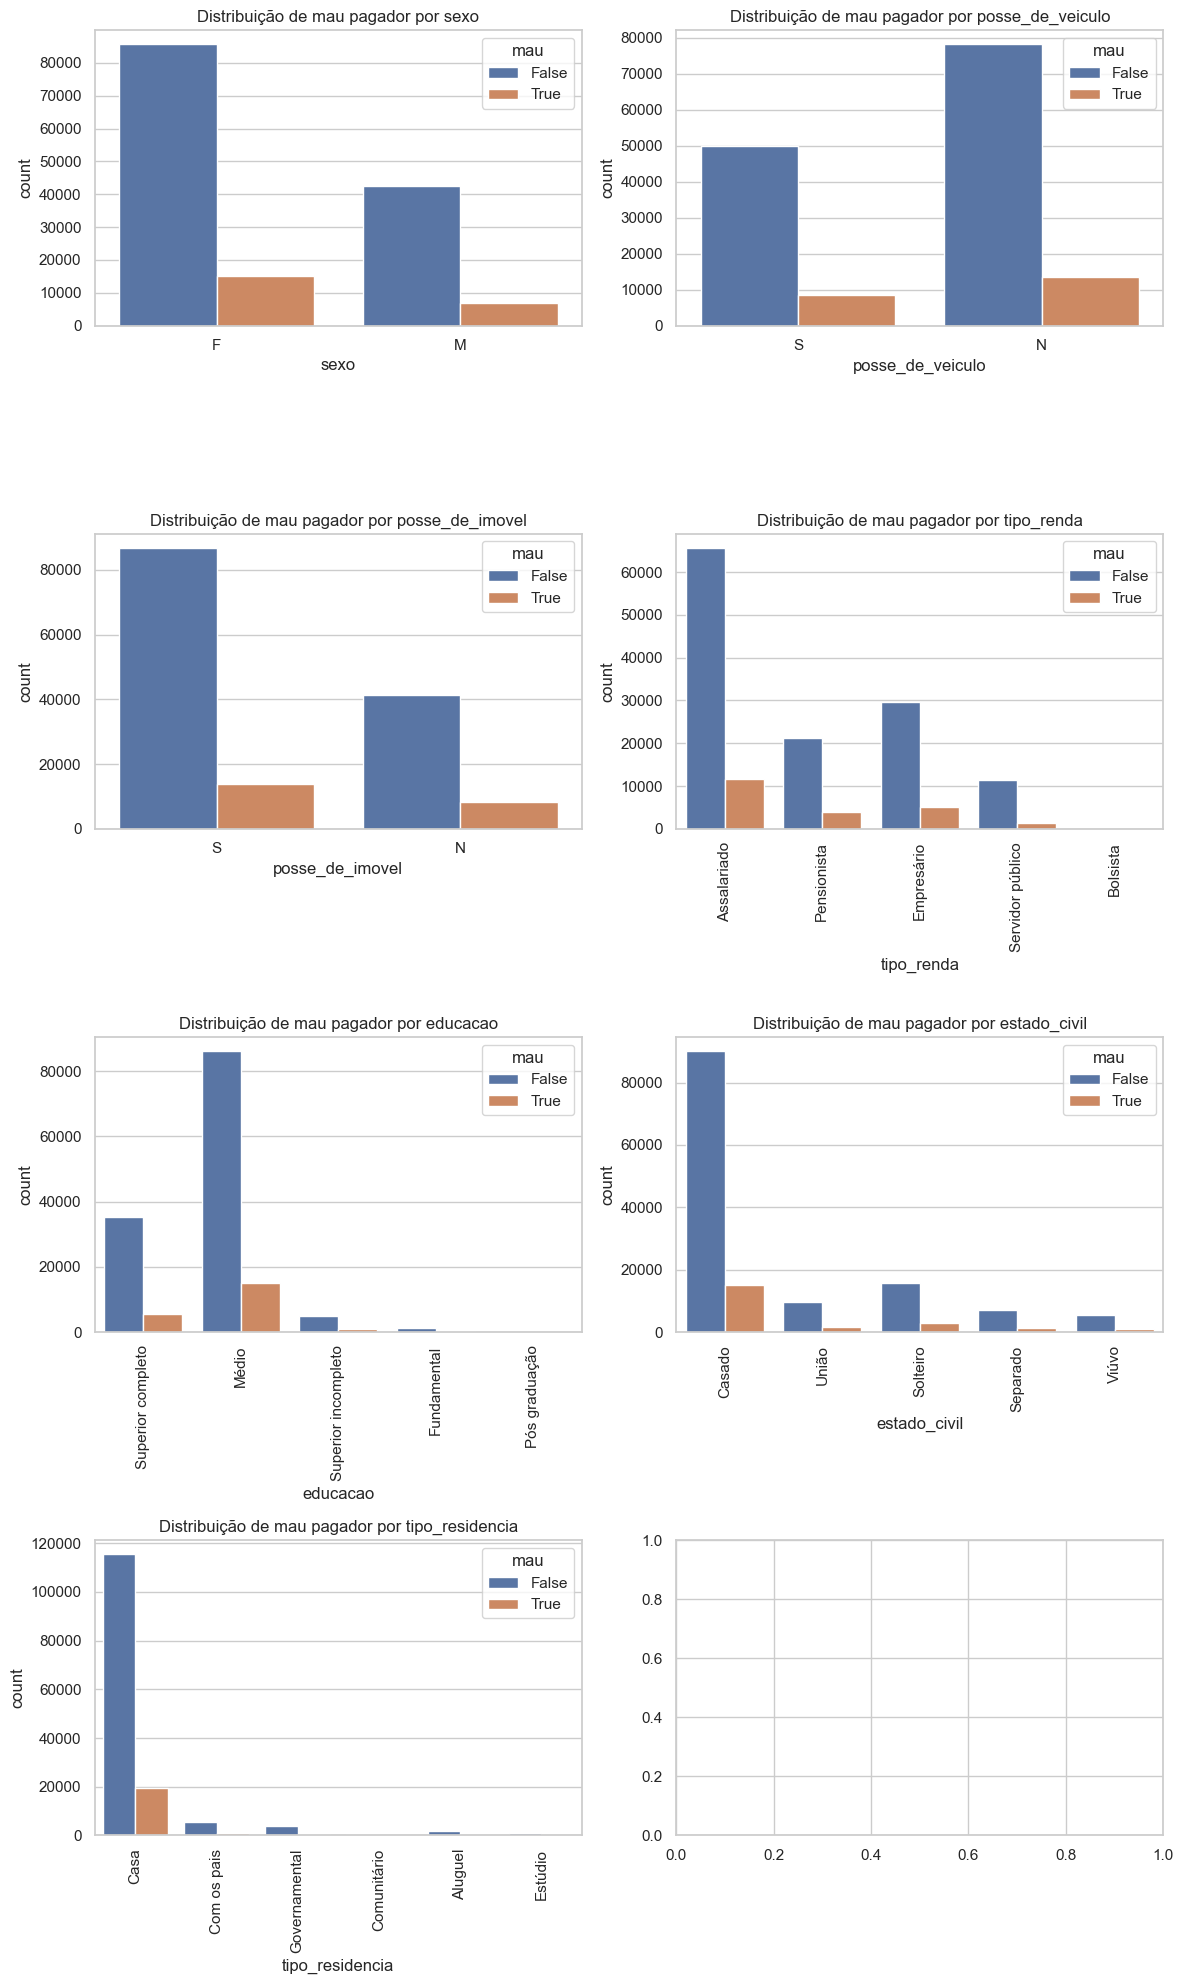

In [6]:
print('ANÁLISE DESCRITIVA BIVARIADA DAS VARIÁVEIS QUALITATIVAS'.center(100))
# Configura o tamanho da figura e o número de linhas e colunas dos subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 20))

# Loop para plotar os gráficos de contagem para as variáveis qualitativas
for i, var in enumerate(var_ql[:-1]):
    plt.subplot(4, 2, i + 1)
    sns.countplot(data=df, x=var, hue='mau')
    plt.title(f'Distribuição de mau pagador por {var}')
    plt.xlabel(var)
    # Orientação do label do eixo x
    if var in ['sexo', 'posse_de_veiculo', 'posse_de_imovel']:
        plt.xticks(rotation=0)
    else:
        plt.xticks(rotation=90)

# Ajusta o espaçamento entre os subplots
plt.tight_layout()

# Exibe os gráficos
plt.show()


                      ANÁLISE DESCRITIVA BIVARIADA DAS VARIÁVEIS QUANTITATIVAS                      


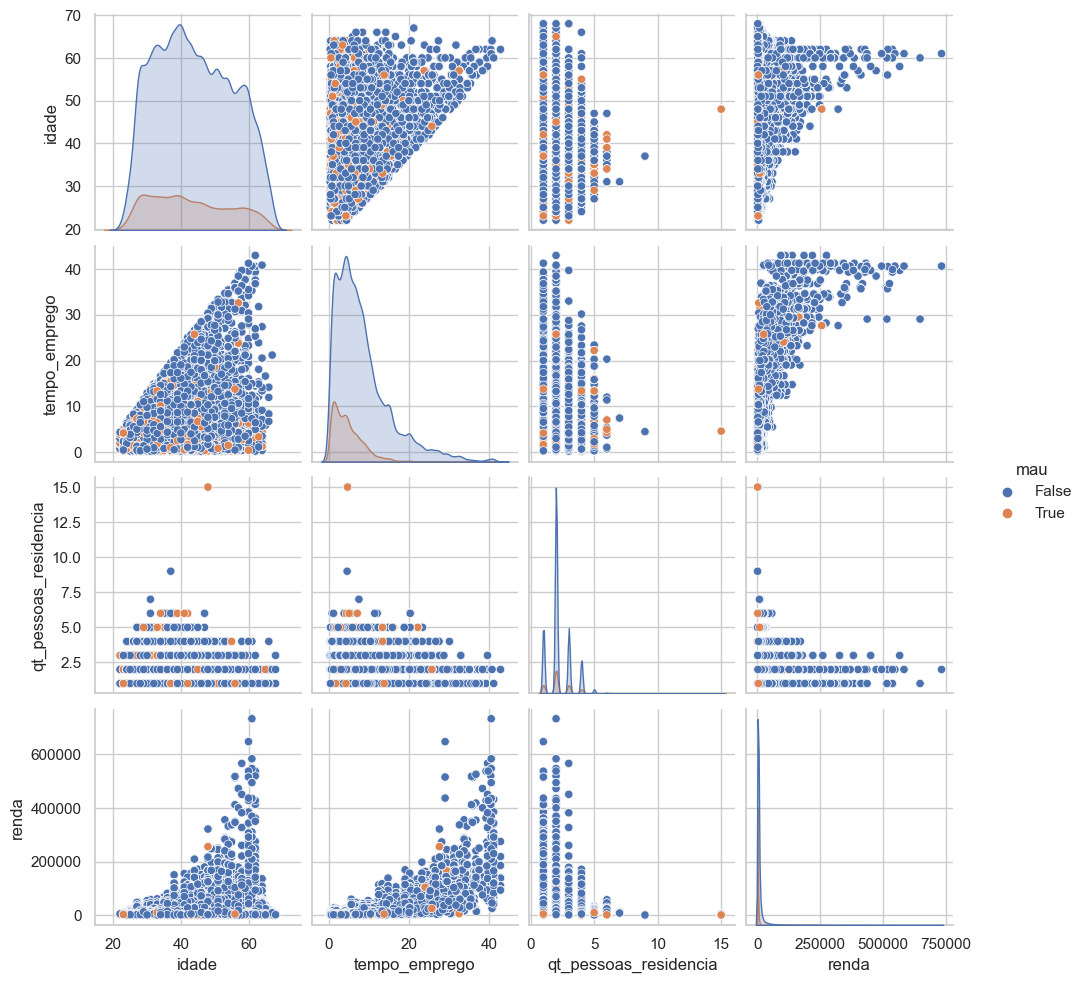

In [7]:
print('ANÁLISE DESCRITIVA BIVARIADA DAS VARIÁVEIS QUANTITATIVAS'.center(100))
# Criar um DataFrame apenas com as variáveis contínuas e a variável 'mau'
df_cont = pd.DataFrame({
    'idade': df['idade'],
    'tempo_emprego': df['tempo_emprego'],
    'qt_pessoas_residencia': df['qt_pessoas_residencia'],
    'renda': df['renda'],
    'mau': df['mau']
})

# Plotar o pairplot
sns.pairplot(data=df_cont, hue='mau')

# Exibir o gráfico
plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [8]:
#Criando metadados
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados

,dtype,nmissing,valores_unicos
data_ref,datetime64[ns],0,3
index,int64,0,16648
sexo,object,0,2
posse_de_veiculo,object,0,2
posse_de_imovel,object,0,2
qtd_filhos,int64,0,8
tipo_renda,object,0,5
educacao,object,0,5
estado_civil,object,0,5
tipo_residencia,object,0,6


#### Tratamento dos valores missing na coluna 'tempo_emprego'

In [9]:
from sklearn.linear_model import LinearRegression

# Criar um DataFrame com as variáveis relevantes para a imputação
df_nan = df[['sexo','idade','estado_civil', 'tipo_residencia', 'educacao', 'tipo_renda', 'tempo_emprego']]
df_nan = pd.get_dummies(df_nan, columns=['sexo','estado_civil','tipo_residencia','educacao', 'tipo_renda'])
display(df_nan.shape)

# Separar os dados conhecidos e os dados a serem imputados
df_known = df_nan[df_nan['tempo_emprego'].notnull()]
df_unknown = df_nan[df_nan['tempo_emprego'].isnull()]

# Separar as variáveis independentes (X) e a variável dependente (y) para o modelo de regressão
X_known = df_known.drop('tempo_emprego', axis=1)
y_known = df_known['tempo_emprego']
X_unknown = df_unknown.drop('tempo_emprego', axis=1)

# Criar e treinar o modelo de regressão
regression_model = LinearRegression()
regression_model.fit(X_known, y_known)

# Realizar a imputação dos valores ausentes
imputed_values = regression_model.predict(X_unknown)

# Preencher os valores ausentes com os valores imputados
df_nan.loc[df_nan['tempo_emprego'].isnull(), 'tempo_emprego'] = imputed_values
df.loc[df['tempo_emprego'].isnull(), 'tempo_emprego'] = imputed_values

if df['tempo_emprego'].equals(df_nan['tempo_emprego']):
    display(df.isna().sum())
    print("Valores NAN preenchidos com sucesso!")
    
else:
    print("ERRO: Colunas não correspondem")

(150000, 25)

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

Valores NAN preenchidos com sucesso!


In [10]:
# Transformar a variável resposta em inteiro
df['mau'] = df.mau.astype('int64')
df.mau.value_counts()

0    128000
1     22000
Name: mau, dtype: int64

In [11]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [12]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype']).iloc[2:,:]
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
sexo,object,0.0,2.0,covariavel
posse_de_veiculo,object,0.0,2.0,covariavel
posse_de_imovel,object,0.0,2.0,covariavel
qtd_filhos,int64,0.0,8.0,covariavel
tipo_renda,object,0.0,5.0,covariavel
educacao,object,0.0,5.0,covariavel
estado_civil,object,0.0,5.0,covariavel
tipo_residencia,object,0.0,6.0,covariavel
idade,int64,0.0,47.0,covariavel
tempo_emprego,float64,0.0,3298.0,covariavel


In [13]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

    
metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0.0,2.0,covariavel,0.001712
posse_de_veiculo,object,0.0,2.0,covariavel,0.000182
posse_de_imovel,object,0.0,2.0,covariavel,0.010444
qtd_filhos,int64,0.0,8.0,covariavel,0.000001
tipo_renda,object,0.0,5.0,covariavel,0.009772
educacao,object,0.0,5.0,covariavel,0.003984
estado_civil,object,0.0,5.0,covariavel,0.000955
tipo_residencia,object,0.0,6.0,covariavel,0.003348
idade,int64,0.0,47.0,covariavel,0.019268
tempo_emprego,float64,0.0,3298.0,covariavel,0.203636


### Tratamento das variáveis discretas

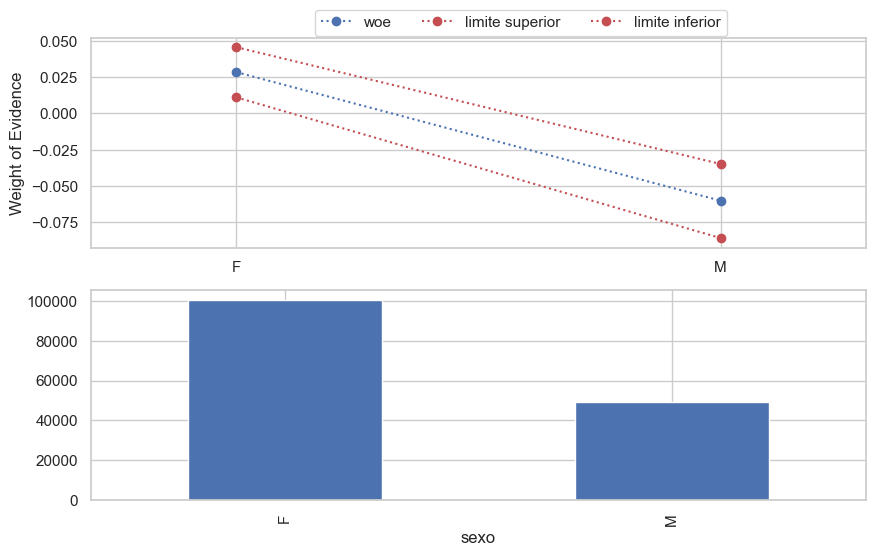

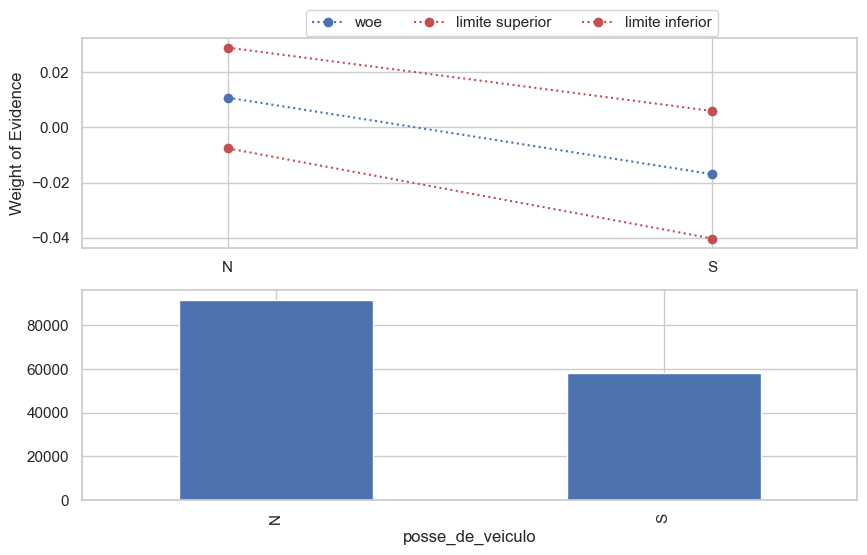

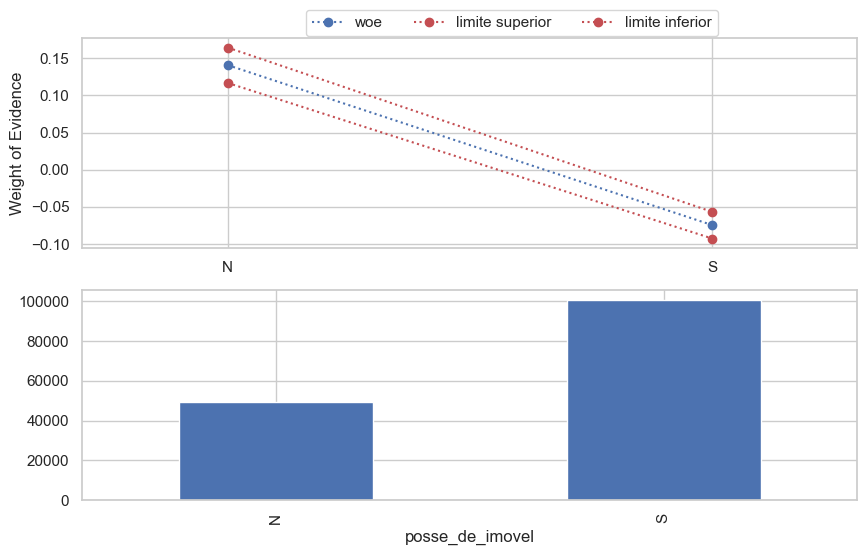

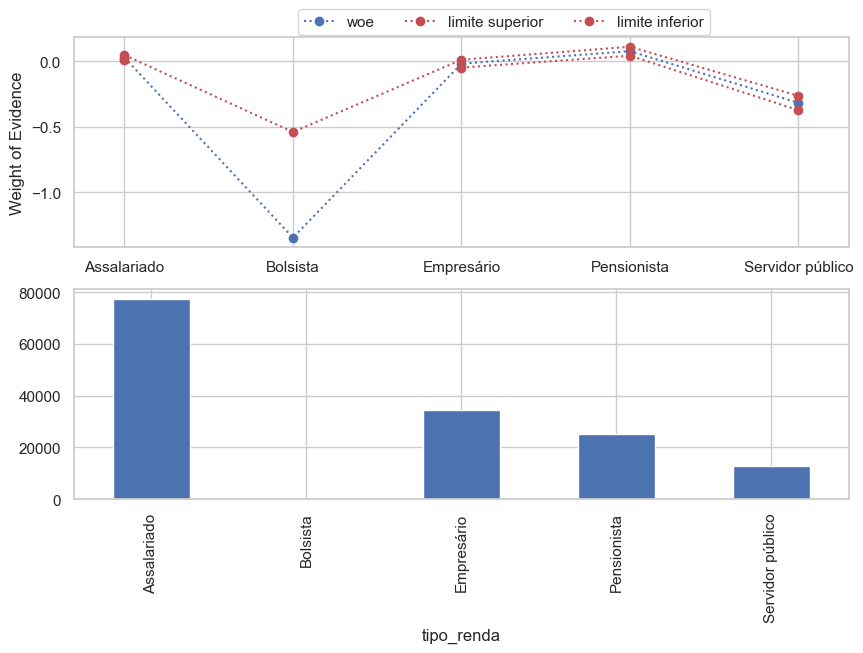

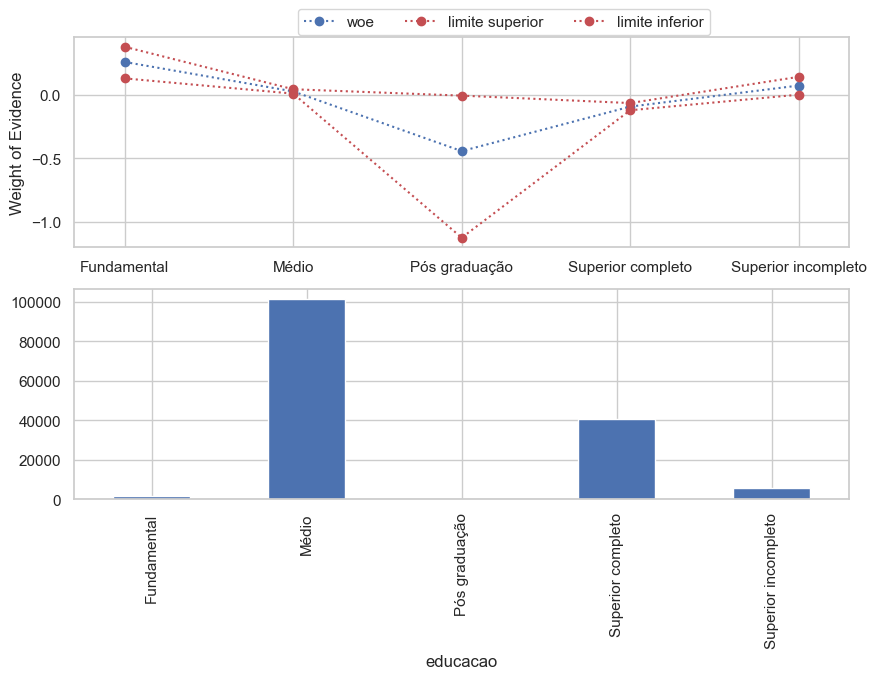

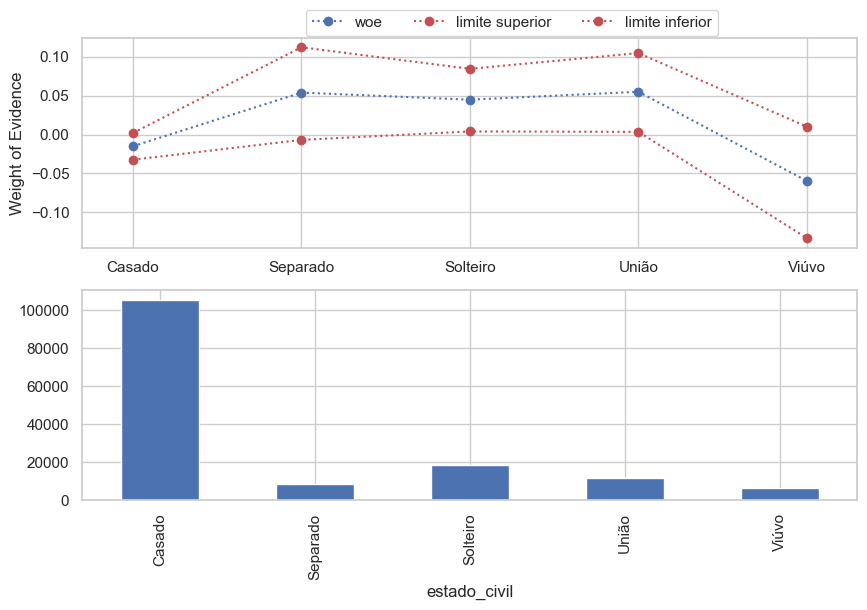

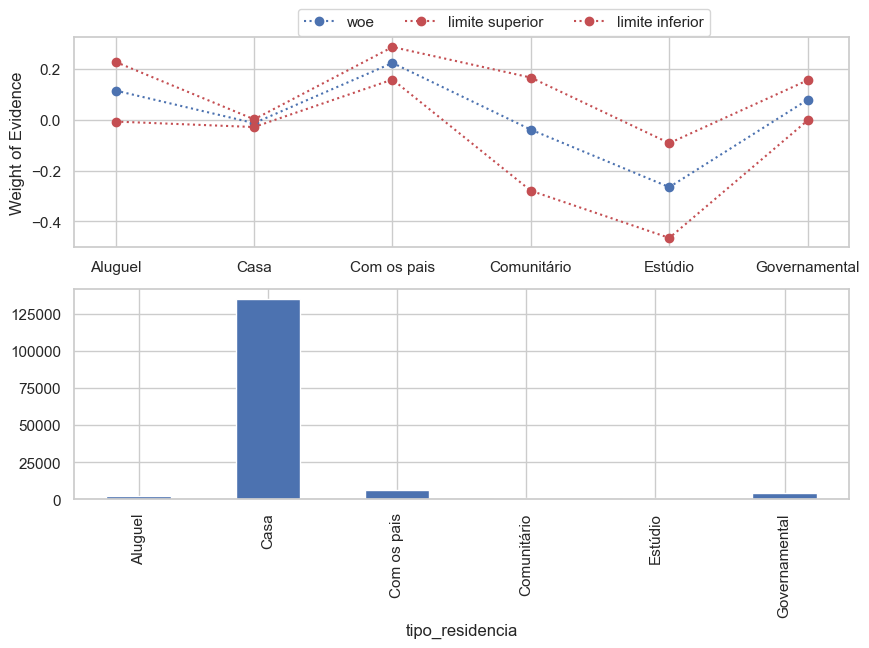

In [14]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(10,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=0)
    
    ax[1] = biv.cont.plot.bar()
    return biv

for i, var in enumerate(var_ql[:-1]):    
    biv_discreta(var, df)

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,65662,11618,0.150336,Assalariado,77280,0.001286,0.152856,0.147817,-1.731965,-1.712372,-1.751830,0.029023,0.048616,0.009158
Bolsista/Pensionista,21265,3943,0.156419,Bolsista/Pensionista,25208,0.002288,0.160903,0.151934,-1.685121,-1.651524,-1.719511,0.075867,0.109463,0.041477
Empresário,29573,4998,0.144572,Empresário,34571,0.001891,0.148279,0.140865,-1.777824,-1.748162,-1.808125,-0.016836,0.012826,-0.047137
Servidor público,11500,1441,0.111352,Servidor público,12941,0.002765,0.116772,0.105931,-2.077010,-2.023362,-2.132992,-0.316022,-0.262375,-0.372004


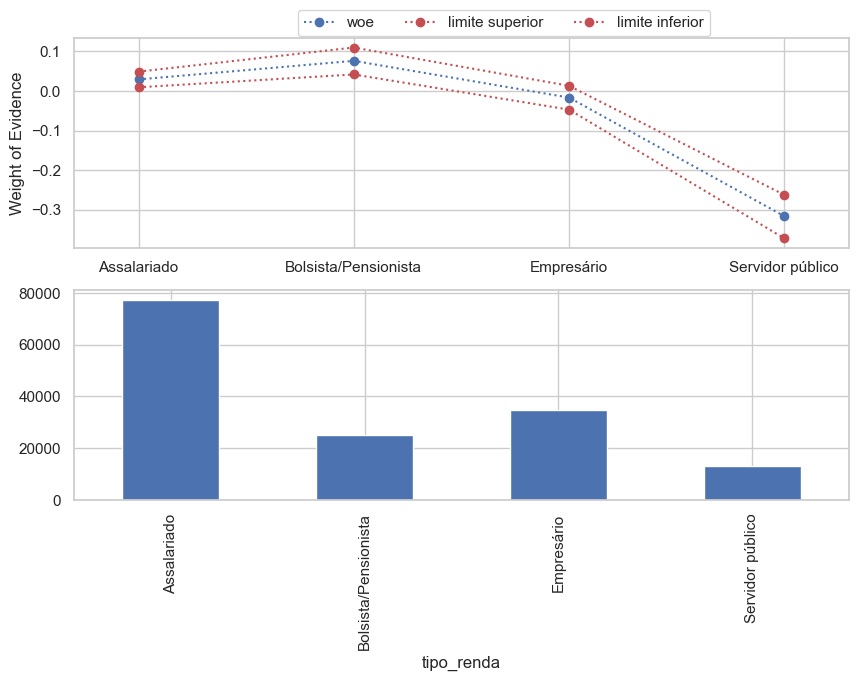

In [15]:
df2 = df.copy()
df2.tipo_renda.replace({'Bolsista': 'Bolsista/Pensionista', 'Pensionista': 'Bolsista/Pensionista'}, inplace=True)
biv_discreta('tipo_renda', df2)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,1369,305,0.182198,Fundamental,1674,0.009434,0.200703,0.163694,-1.501524,-1.381907,-1.630998,0.259464,0.379081,0.129990
Médio,86167,15220,0.150118,Médio,101387,0.001122,0.152317,0.147919,-1.733677,-1.716547,-1.751015,0.027311,0.044441,0.009973
Sup.Compl+Pós,35475,5552,0.135326,Sup.Compl+Pós,41027,0.001689,0.138636,0.132015,-1.854670,-1.826669,-1.883255,-0.093682,-0.065681,-0.122267
Superior incompleto,4989,923,0.156123,Superior incompleto,5912,0.004721,0.165377,0.146869,-1.687362,-1.618749,-1.759373,0.073626,0.142238,0.001615


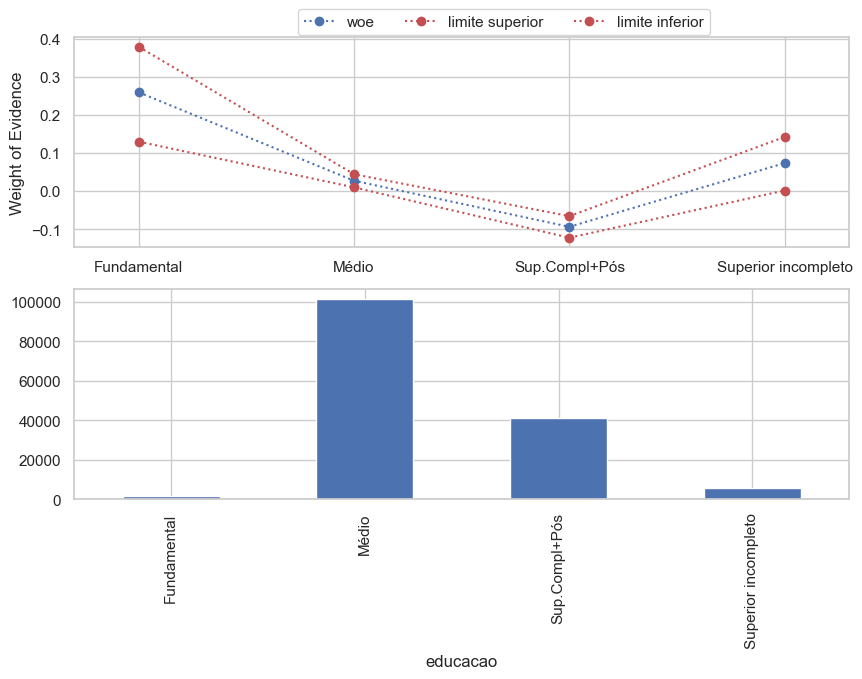

In [16]:
df2.educacao.replace({'Pós graduação': 'Sup.Compl+Pós', 'Superior completo': 'Sup.Compl+Pós'}, inplace=True)
biv_discreta('educacao', df2)

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,1750,337,0.161476,Aluguel,2087,0.008055,0.177272,0.145680,-1.647288,-1.534941,-1.768896,0.113700,0.226047,-0.007908
Casa,115401,19557,0.144912,Casa,134958,0.000958,0.146790,0.143034,-1.775080,-1.760004,-1.790318,-0.014092,0.000984,-0.029331
Com os pais,5353,1149,0.176715,Com os pais,6502,0.004730,0.185988,0.167442,-1.538765,-1.476294,-1.603866,0.222223,0.284693,0.157121
Estúdio/Comun.,1534,221,0.125926,Estúdio/Comun.,1755,0.007919,0.141458,0.110393,-1.937471,-1.803229,-2.086729,-0.176483,-0.042242,-0.325741
Governamental,3962,736,0.156662,Governamental,4698,0.005303,0.167059,0.146266,-1.683274,-1.606617,-1.764193,0.077714,0.154371,-0.003206


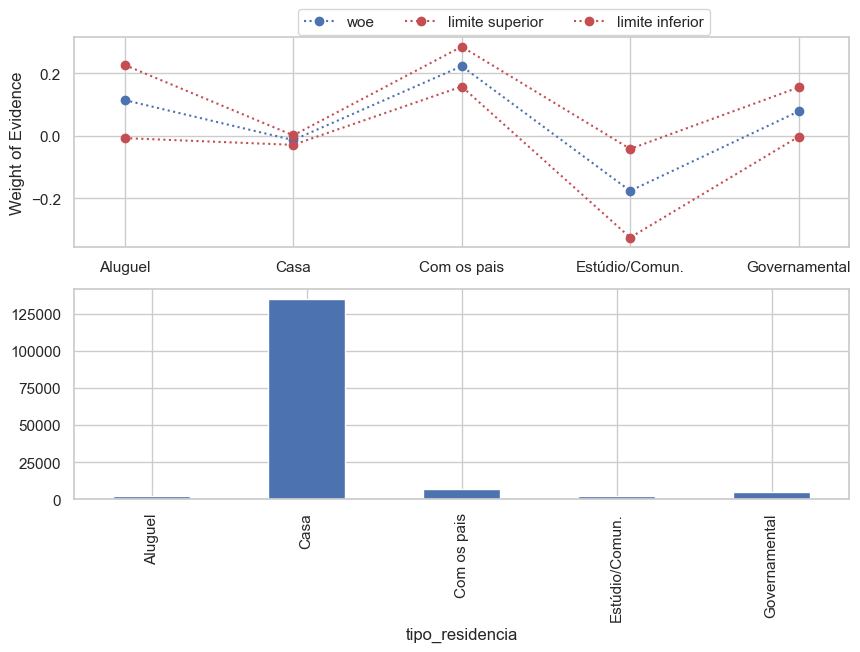

In [17]:
df2.tipo_residencia.replace({'Comunitário': 'Estúdio/Comun.', 'Estúdio': 'Estúdio/Comun.'}, inplace=True)
biv_discreta('tipo_residencia', df2)

### Tratamento das variáveis contínuas

In [77]:
# Identificando as variáveis contínuas
variaveis_continuas=df2.select_dtypes(exclude='object').columns.values[2:7].tolist()
print(f'Variáveis contínuas: {variaveis_continuas}')


Variáveis contínuas: ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']


In [19]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

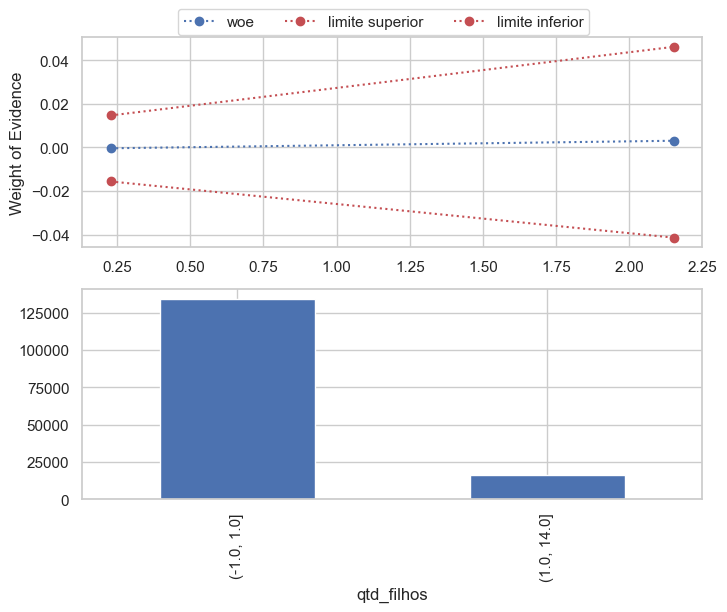

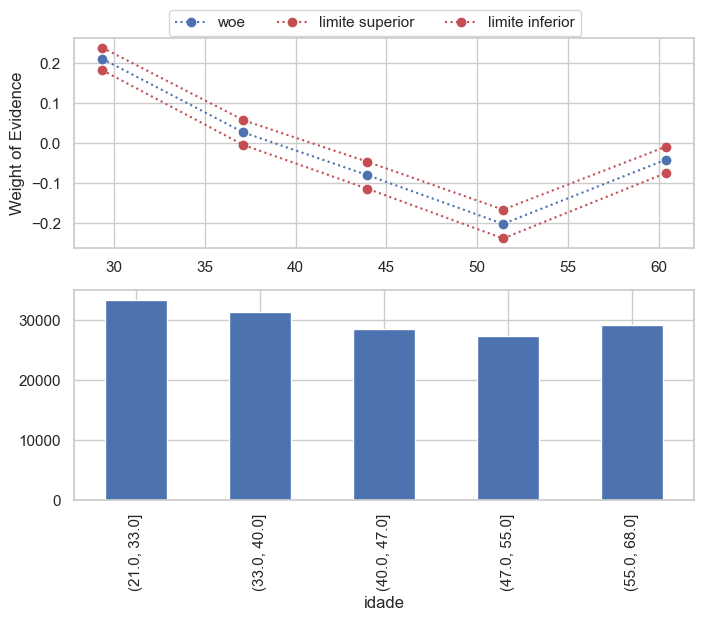

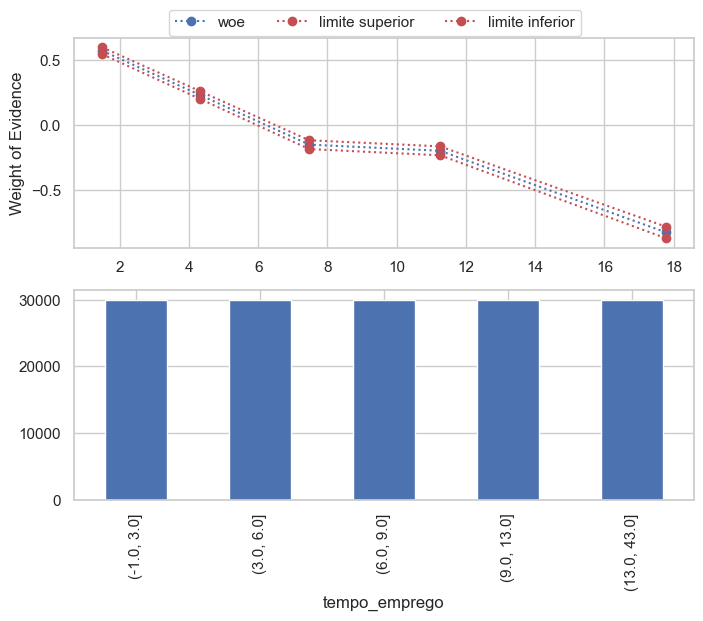

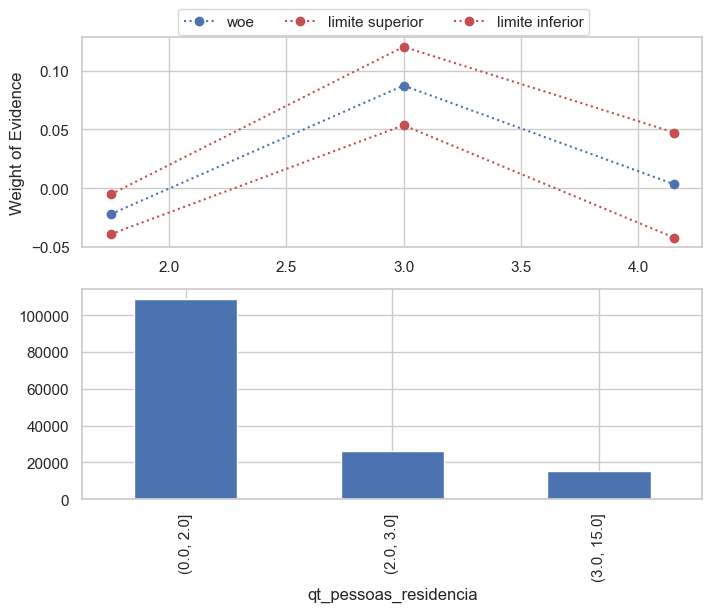

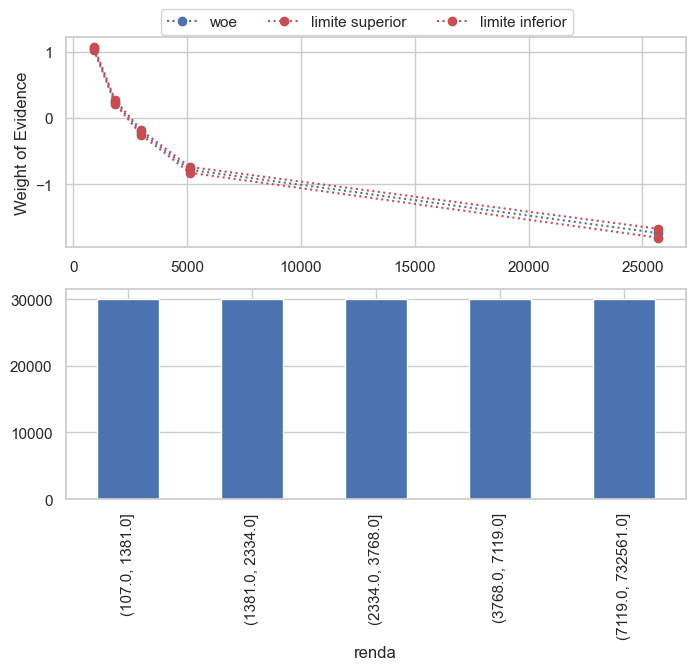

In [20]:
for i, var in enumerate(variaveis_continuas):
    biv_continua(var, 5,df2)

### Scorecard inicial

In [21]:
# formatando a fórmula para definir a equação da regressão
variaveis=' + '.join(list(df2.columns[2:-2]))
target='mau'
formula = '''
{} ~ {}
'''.format(target, variaveis)
formula

'\nmau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda\n'

In [22]:
rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               150000
Model:                            GLM   Df Residuals:                   149977
Model Family:                Binomial   Df Model:                           22
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -57179.
Date:                Tue, 30 May 2023   Deviance:                   1.1432e+05
Time:                        15:57:47   Pearson chi2:                 1.41e+16
No. Iterations:                     9   Pseudo R-squ. (CS):            0.06889
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -0.7167      0.285     -2.511      0.012      -1.276      -0.157
sexo[T.M]                             -0.1394      0.018     -7.796      0.000      -0.174      -0.104
posse_de_veiculo[T.S]                  0.0088      0.017      0.520      0.603      -0.024       0.042
posse_de_imovel[T.S]                  -0.1069      0.016     -6.580      0.000      -0.139      -0.075
tipo_renda[T.Bolsista/Pensionista]     0.0724      0.031      2.337      0.019       0.012       0.133
tipo_renda[T.Empresário]              -0.0468      0.019     -2.444      0.015      -0.084      -0.009
tipo_renda[T.Servidor público]        -0.0251      0.031     -0.801      0.423      -0.086       0.036
educacao[T.Médio]                     -0.1525      0.066     -2.321      0.020      -0.281      -0.024
educacao[T.Sup.Compl+Pós]             -0.2142      0.067     -3.193      0.001      -0.346      -0.083
educacao[T.Superior incompleto]       -0.1930      0.075     -2.562      0.010      -0.341      -0.045
estado_civil[T.Separado]               0.1857      0.138      1.345      0.179      -0.085       0.456
estado_civil[T.Solteiro]               0.1565      0.135      1.157      0.247      -0.109       0.422
estado_civil[T.União]                 -0.0058      0.028     -0.205      0.837      -0.061       0.050
estado_civil[T.Viúvo]                  0.0759      0.140      0.542      0.588      -0.199       0.350
tipo_residencia[T.Casa]               -0.0232      0.062     -0.373      0.709      -0.145       0.099
tipo_residencia[T.Com os pais]        -0.0145      0.070     -0.207      0.836      -0.151       0.122
tipo_residencia[T.Estúdio/Comun.]     -0.1536      0.096     -1.595      0.111      -0.342       0.035
tipo_residencia[T.Governamental]       0.0431      0.074      0.580      0.562      -0.103       0.189
qtd_filhos                            -0.1476      0.134     -1.097      0.272      -0.411       0.116
idade                                 -0.0005      0.001     -0.522      0.602      -0.002       0.001
tempo_emprego                         -0.0273      0.003    -10.845      0.000      -0.032      -0.022
qt_pessoas_residencia                  0.1449      0.134      1.080      0.280      -0.118       0.408
renda                                 -0.0002    4.4e-06    -55.386      0.000      -0.000      -0.000
======================================================================================================
"""

In [23]:
metadados.sort_values(by='IV', ascending=False)

,dtype,nmissing,valores_unicos,papel,IV
renda,float64,0.0,46077.0,covariavel,0.744982
tempo_emprego,float64,0.0,3298.0,covariavel,0.203636
idade,int64,0.0,47.0,covariavel,0.019268
posse_de_imovel,object,0.0,2.0,covariavel,0.010444
tipo_renda,object,0.0,5.0,covariavel,0.009772
educacao,object,0.0,5.0,covariavel,0.003984
tipo_residencia,object,0.0,6.0,covariavel,0.003348
sexo,object,0.0,2.0,covariavel,0.001712
qt_pessoas_residencia,float64,0.0,9.0,covariavel,0.001711
estado_civil,object,0.0,5.0,covariavel,0.000955


In [24]:
IV = metadados['IV']
indices = []

for variavel, valor_IV in IV.items():
    if valor_IV > 0.01:
        indices.append(variavel)

display(' + '.join(indices))

# formatando a fórmula para definir a equação da regressão
variaveis=' + '.join(indices)
target='mau'
formula = '''
{} ~ {}
'''.format(target, variaveis)


'posse_de_imovel + idade + tempo_emprego + renda'

In [25]:
rl = smf.glm(formula, data=df2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               150000
Model:                            GLM   Df Residuals:                   149995
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -57234.
Date:                Tue, 30 May 2023   Deviance:                   1.1443e+05
Time:                        15:57:48   Pearson chi2:                 1.51e+16
No. Iterations:                     9   Pseudo R-squ. (CS):            0.06821
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.7820      0.031    -25.066      0.000      -0.843      -0.721
posse_de_imovel[T.S]    -0.1016      0.016     -6.412      0.000      -0.133      -0.071
idade                    0.0020      0.001      2.631      0.009       0.001       0.004
tempo_emprego           -0.0219      0.002    -10.208      0.000      -0.026      -0.018
renda                   -0.0003   4.21e-06    -59.959      0.000      -0.000      -0.000
========================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

#### Avaliando a acurácia do modelo

In [26]:
df2['score'] = rl.predict(df2)

# Acurácia
acc = metrics.accuracy_score(df2.mau, df2.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df2.mau, df2.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df2.loc[df2.mau == 1, 'score'], df2.loc[df2.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 35.5% 
AUC: 73.5% 
GINI: 46.9%
KS: 34.3%


### Características do modelo

In [27]:
def perfil_var(df, var, ev='mau', score='score', ncat=None):
    
    _df = df.copy()
    _df['ev'] = _df[ev]
    _df['nev'] = 1 - _df[ev]
    
    if ncat == None:
        g = _df.groupby(var)
    else:
        g = _df.groupby(pd.qcut(_df[var], ncat, duplicates='drop'))

    tg = g.agg({score:'mean', 'ev':'sum', 'nev':'sum'})
    tg['total'] = tg.ev + tg.nev
    tg['distribuição'] = tg.total/tg.total.sum()

    tg['total_acum'] = tg['total'].cumsum()
    tg['ev_acum']    = tg.ev.cumsum()
    tg['nev_acum']   = tg.nev.cumsum()

    tg['tx_ev']     = tg.ev/tg.total
    tg['ep']        = (tg.tx_ev*(1-tg.tx_ev)/tg.total)**.5
    tg['tx_ev_sup'] = tg.score+t.ppf([0.025], tg.total-1)*tg.ep
    tg['tx_ev_inf'] = tg.score+t.ppf([0.975], tg.total-1)*tg.ep

    fig, ax = plt.subplots()
    
    if ncat == None:
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).score    , 'b-' , label='esperado')
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).tx_ev    , 'r--', label='observado')
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).tx_ev_sup, 'r:',  label='obs-ls')
        ax.plot(tg.reset_index()[var], tg.reset_index(drop=True).tx_ev_inf, 'r:',  label='obs-li')
    else:
        tg[var+'_med'] = g[var].mean()
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).score    , 'b-' , label='esperado')
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).tx_ev    , 'r--', label='observado')
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).tx_ev_sup, 'r:',  label='obs-ls')
        ax.plot(tg[var+'_med'], tg.reset_index(drop=True).tx_ev_inf, 'r:',  label='obs-li')
    return tg[['distribuição', score, 'tx_ev']]
indices

['posse_de_imovel', 'idade', 'tempo_emprego', 'renda']

,idade,distribuição,score,tx_ev
0,"(21.999, 29.0]",11.1%,18.5%,18.9%
1,"(29.0, 33.0]",11.1%,16.5%,16.1%
2,"(33.0, 36.0]",8.3%,15.4%,15.3%
3,"(36.0, 40.0]",12.6%,14.6%,14.8%
4,"(40.0, 43.0]",8.6%,13.5%,13.1%
5,"(43.0, 47.0]",10.4%,14.2%,14.2%
6,"(47.0, 51.0]",9.5%,12.2%,12.1%
7,"(51.0, 55.0]",8.8%,13.0%,12.5%
8,"(55.0, 60.0]",10.9%,13.6%,13.5%
9,"(60.0, 68.0]",8.5%,14.4%,15.1%


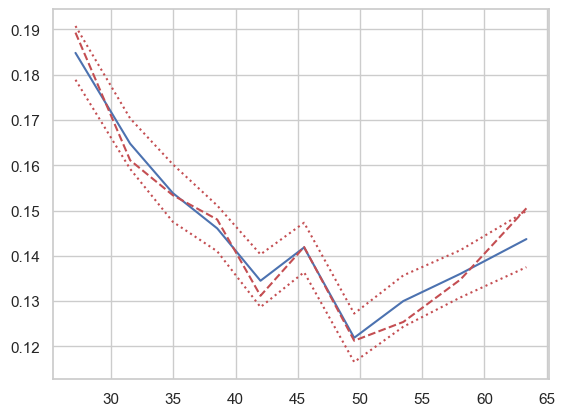

In [28]:
tg = perfil_var(df2, 'idade', ncat=10)
tg.reset_index().style.format({'score':'{:.1%}', 'tx_ev':'{:.1%}', 'distribuição':'{:.1%}'})

,tempo_emprego,distribuição,score,tx_ev
0,"(0.11699999999999999, 1.468]",10.0%,22.7%,24.6%
1,"(1.468, 2.936]",10.0%,21.0%,22.0%
2,"(2.936, 4.304]",10.1%,19.2%,18.8%
3,"(4.304, 5.751]",10.0%,17.6%,16.8%
4,"(5.751, 7.433]",10.0%,15.0%,13.7%
5,"(7.433, 9.389]",10.0%,13.2%,12.0%
6,"(9.389, 11.427]",10.2%,12.0%,11.5%
7,"(11.427, 12.634]",9.8%,13.3%,13.3%
8,"(12.634, 15.216]",10.0%,10.7%,11.4%
9,"(15.216, 42.907]",10.0%,1.8%,2.6%


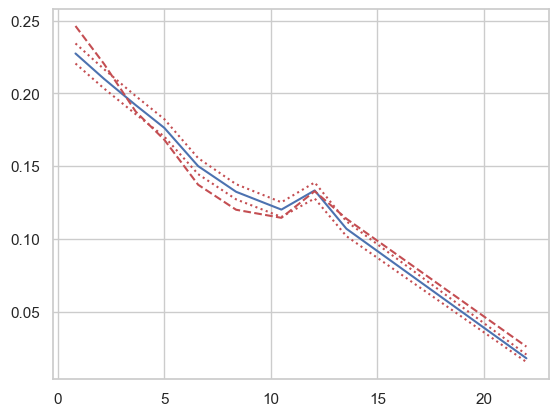

In [29]:
tg = perfil_var(df2, 'tempo_emprego', ncat=10)
tg.reset_index().style.format({'score':'{:.1%}', 'tx_ev':'{:.1%}', 'distribuição':'{:.1%}'})

,renda,distribuição,score,tx_ev
0,"(107.669, 934.3]",10.0%,26.7%,39.3%
1,"(934.3, 1381.31]",10.0%,23.8%,26.6%
2,"(1381.31, 1826.3]",10.0%,21.6%,19.8%
3,"(1826.3, 2334.02]",10.0%,19.4%,16.1%
4,"(2334.02, 2952.38]",10.0%,17.1%,13.1%
5,"(2952.38, 3767.51]",10.0%,14.6%,11.2%
6,"(3767.51, 4974.52]",10.0%,11.6%,8.3%
7,"(4974.52, 7118.68]",10.0%,8.0%,6.3%
8,"(7118.68, 12823.3]",10.0%,3.6%,4.4%
9,"(12823.3, 732561.26]",10.0%,0.3%,1.5%


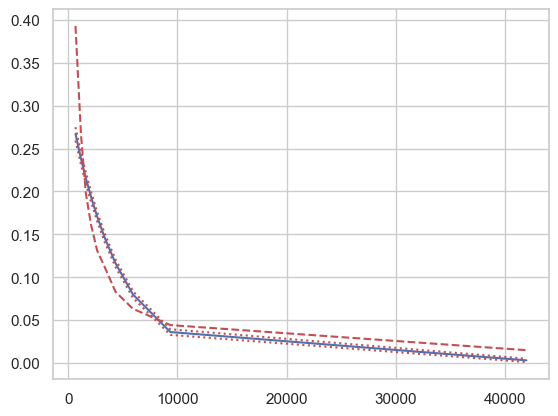

In [30]:
tg = perfil_var(df2, 'renda', ncat=10)
tg.reset_index().style.format({'score':'{:.1%}', 'tx_ev':'{:.1%}', 'distribuição':'{:.1%}'})

# Avaliando as métricas na base out of time

In [31]:
df3=dados[(dados['data_ref']>='2015-10-01')&(dados['data_ref']<='2015-12-01')].copy()
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 450000 to 599999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               150000 non-null  datetime64[ns]
 1   index                  150000 non-null  int64         
 2   sexo                   150000 non-null  object        
 3   posse_de_veiculo       150000 non-null  object        
 4   posse_de_imovel        150000 non-null  object        
 5   qtd_filhos             150000 non-null  int64         
 6   tipo_renda             150000 non-null  object        
 7   educacao               150000 non-null  object        
 8   estado_civil           150000 non-null  object        
 9   tipo_residencia        150000 non-null  object        
 10  idade                  150000 non-null  int64         
 11  tempo_emprego          124868 non-null  float64       
 12  qt_pessoas_residencia  150000 non-null 

In [32]:
# Transformar a variável resposta em inteiro
df3['mau'] = df3.mau.astype('int64')
df3.mau.value_counts()

0    138793
1     11207
Name: mau, dtype: int64

In [33]:
df3.isna().sum()

data_ref                     0
index                        0
sexo                         0
posse_de_veiculo             0
posse_de_imovel              0
qtd_filhos                   0
tipo_renda                   0
educacao                     0
estado_civil                 0
tipo_residencia              0
idade                        0
tempo_emprego            25132
qt_pessoas_residencia        0
renda                        0
mau                          0
dtype: int64

In [34]:
# Tratando valores NAN
from sklearn.linear_model import LinearRegression

# Criar um DataFrame com as variáveis relevantes para a imputação
df3_nan = df3[['sexo','idade','estado_civil', 'tipo_residencia', 'educacao', 'tipo_renda', 'tempo_emprego']]
df3_nan = pd.get_dummies(df3_nan, columns=['sexo','estado_civil','tipo_residencia','educacao', 'tipo_renda'])
display(df3_nan.shape)

# Separar os dados conhecidos e os dados a serem imputados
df3_known = df3_nan[df3_nan['tempo_emprego'].notnull()]
df3_unknown = df3_nan[df3_nan['tempo_emprego'].isnull()]

# Separar as variáveis independentes (X) e a variável dependente (y) para o modelo de regressão
X_known = df3_known.drop('tempo_emprego', axis=1)
y_known = df3_known['tempo_emprego']
X_unknown = df3_unknown.drop('tempo_emprego', axis=1)

# Criar e treinar o modelo de regressão
regression_model = LinearRegression()
regression_model.fit(X_known, y_known)

# Realizar a imputação dos valores ausentes
imputed_values = regression_model.predict(X_unknown)

# Preencher os valores ausentes com os valores imputados
df3_nan.loc[df3_nan['tempo_emprego'].isnull(), 'tempo_emprego'] = imputed_values
df3.loc[df3['tempo_emprego'].isnull(), 'tempo_emprego'] = imputed_values

if df3['tempo_emprego'].equals(df3_nan['tempo_emprego']):
    display(df3.isna().sum())
    print("Valores NAN preenchidos com sucesso!")
    
else:
    print("ERRO: Colunas não correspondem")

(150000, 25)

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

Valores NAN preenchidos com sucesso!


In [35]:
rl = smf.glm(formula, data=df3, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               150000
Model:                            GLM   Df Residuals:                   149995
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36703.
Date:                Tue, 30 May 2023   Deviance:                       73386.
Time:                        15:57:50   Pearson chi2:                 1.77e+16
No. Iterations:                    10   Pseudo R-squ. (CS):            0.04108
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.5449      0.041    -37.467      0.000      -1.626      -1.464
posse_de_imovel[T.S]    -0.0952      0.021     -4.536      0.000      -0.136      -0.054
idade                    0.0033      0.001      3.256      0.001       0.001       0.005
tempo_emprego           -0.0234      0.003     -8.081      0.000      -0.029      -0.018
renda                   -0.0001   2.59e-06    -46.796      0.000      -0.000      -0.000
========================================================================================
"""

In [36]:
df3['score'] = rl.predict(df3)

# Acurácia
acc = metrics.accuracy_score(df3.mau, df3.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df3.mau, df3.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df3.loc[df3.mau == 1, 'score'], df3.loc[df3.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))


Acurácia: 49.6% 
AUC: 74.3% 
GINI: 48.5%
KS: 36.0%


# Avaliando as métricas na base Desenvolvimento

In [37]:
#Gerando base Desenvolvimento
df4=dados[(dados['data_ref']<'2015-10-01')].copy()
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450000 entries, 0 to 449999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               450000 non-null  datetime64[ns]
 1   index                  450000 non-null  int64         
 2   sexo                   450000 non-null  object        
 3   posse_de_veiculo       450000 non-null  object        
 4   posse_de_imovel        450000 non-null  object        
 5   qtd_filhos             450000 non-null  int64         
 6   tipo_renda             450000 non-null  object        
 7   educacao               450000 non-null  object        
 8   estado_civil           450000 non-null  object        
 9   tipo_residencia        450000 non-null  object        
 10  idade                  450000 non-null  int64         
 11  tempo_emprego          374257 non-null  float64       
 12  qt_pessoas_residencia  450000 non-null  floa

In [38]:
# Transformar a variável resposta em inteiro
df4['mau'] = df4.mau.astype('int64')
df4.mau.value_counts()

0    424564
1     25436
Name: mau, dtype: int64

In [39]:
#Conhecendo os valores NAN
df4.isna().sum()

data_ref                     0
index                        0
sexo                         0
posse_de_veiculo             0
posse_de_imovel              0
qtd_filhos                   0
tipo_renda                   0
educacao                     0
estado_civil                 0
tipo_residencia              0
idade                        0
tempo_emprego            75743
qt_pessoas_residencia        0
renda                        0
mau                          0
dtype: int64

In [40]:
# Tratando valores NAN
from sklearn.linear_model import LinearRegression

# Criar um DataFrame com as variáveis relevantes para a imputação
df4_nan = df4[['sexo','idade','estado_civil', 'tipo_residencia', 'educacao', 'tipo_renda', 'tempo_emprego']]
df4_nan = pd.get_dummies(df4_nan, columns=['sexo','estado_civil','tipo_residencia','educacao', 'tipo_renda'])
display(df4_nan.shape)

# Separar os dados conhecidos e os dados a serem imputados
df4_known = df4_nan[df4_nan['tempo_emprego'].notnull()]
df4_unknown = df4_nan[df4_nan['tempo_emprego'].isnull()]

# Separar as variáveis independentes (X) e a variável dependente (y) para o modelo de regressão
X_known = df4_known.drop('tempo_emprego', axis=1)
y_known = df4_known['tempo_emprego']
X_unknown = df4_unknown.drop('tempo_emprego', axis=1)

# Criar e treinar o modelo de regressão
regression_model = LinearRegression()
regression_model.fit(X_known, y_known)

# Realizar a imputação dos valores ausentes
imputed_values = regression_model.predict(X_unknown)

# Preencher os valores ausentes com os valores imputados
df4_nan.loc[df4_nan['tempo_emprego'].isnull(), 'tempo_emprego'] = imputed_values
df4.loc[df4['tempo_emprego'].isnull(), 'tempo_emprego'] = imputed_values

if df4['tempo_emprego'].equals(df4_nan['tempo_emprego']):
    display(df4.isna().sum())
    print("Valores NAN preenchidos com sucesso!")
    
else:
    print("ERRO: Colunas não correspondem")

(450000, 25)

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

Valores NAN preenchidos com sucesso!


In [41]:
rl = smf.glm(formula, data=df4, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               450000
Model:                            GLM   Df Residuals:                   449995
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -88210.
Date:                Tue, 30 May 2023   Deviance:                   1.7631e+05
Time:                        15:57:55   Pearson chi2:                 9.81e+15
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04165
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.6605      0.027    -61.957      0.000      -1.713      -1.608
posse_de_imovel[T.S]    -0.0751      0.014     -5.442      0.000      -0.102      -0.048
idade                    0.0014      0.001      2.134      0.033       0.000       0.003
tempo_emprego           -0.0180      0.002     -9.563      0.000      -0.022      -0.014
renda                -9.921e-05   1.17e-06    -84.589      0.000      -0.000   -9.69e-05
========================================================================================
"""

In [42]:
df4['score'] = rl.predict(df4)

# Acurácia
acc = metrics.accuracy_score(df4.mau, df4.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df4.mau, df4.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df4.loc[df4.mau == 1, 'score'], df4.loc[df4.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))


Acurácia: 62.7% 
AUC: 77.3% 
GINI: 54.7%
KS: 40.6%


In [85]:
choice_var=df4.select_dtypes(exclude='object').columns.values[2:7].tolist()
choice_var

['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

In [149]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Opções disponíveis
options = df4.select_dtypes(exclude='object').columns.values[2:7].tolist()

# RadioButtons para escolher a variável
choice_var = widgets.RadioButtons(
    options=options,
    description='Escolha uma variável:'
)

# Botão para exibir os resultados
display_button = widgets.Button(description='Exibir resultados')

# Função para tratar o clique do botão
def exibir_resultados(button):
    escolha = choice_var.value
    if escolha is None:
        return
    with output_area:
        clear_output(wait=True)  # Limpa a área de saída antes de exibir os resultados
        print("Variável selecionada:", escolha)
        tg = perfil_var(df4, escolha, ncat=10)
        styled_tg =tg.reset_index().style.format({'score':'{:.1%}', 'tx_ev':'{:.1%}', 'distribuição':'{:.1%}'})
        display(styled_tg)
        

# Conectar a função ao evento de clique do botão
display_button.on_click(exibir_resultados)

# Exibição do RadioButtons e do botão
display(choice_var)
display(display_button)

# Criação inicial da área de saída
output_area = widgets.Output()
display(output_area)

# Exibe a área de saída vazia
with output_area:
    clear_output(wait=True)


RadioButtons(description='Escolha uma variável:', options=('qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas…

Button(description='Exibir resultados', style=ButtonStyle())

Output()